# **Метрики удобочитаемости, лексического разнообразия и пр. для датасета**

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import colorsys
plt.style.use('ggplot')

## Объединение данных в один датасет

In [96]:
# читаем певрый трейн файл (примерно 1/3 всех объектов)
df1 = pd.read_csv('TRAIN_500words_lemmatized_metrics_part1.csv', sep=',') 
df1.index = df1['Unnamed: 0']
df1['author'].unique()

array(['anton-chekhov', 'dmitriy-mamin-sibiryak', 'fedor-dostoevskii'],
      dtype=object)

In [97]:
# читаем второй трейн файл
df2 = pd.read_csv('TRAIN_500words_lemmatized_metrics_part2.csv', sep=',') 
df2.index = df2['Unnamed: 0']
df2['author'].unique()

array(['fedor-dostoevskii', 'ivan-goncharov', 'ivan-turgenev',
       'lev-tolstoi', 'maksim-gorkii', 'nikolai-gogol', 'sergey-aksakov'],
      dtype=object)

In [98]:
df = df1.append(df2)

In [99]:
# удаляем одинаковые строки в объединенном датасете
df = df.drop_duplicates(['Unnamed: 0'])
df = df.drop(['Unnamed: 0', 'Unnamed: 21', 'Unnamed: 20'], axis=1)

In [100]:
df.drop(df[df['n_sents'].isna()==True].index, inplace=True) # это образовавшаяся пустая строка на стыке двух кусков датасета

In [101]:
df.shape

(9758, 47)

In [102]:
# показатели среднего/женского/мужского рода, пассивного/активного залога и т.д. выражаем как долю от общего числа слов в куске текста
for column in ['neut',
       'masc', 'femn', 'plur','sing', 'pres', 'past', 'futr', 'pssv', 'actv', '2per',
       '3per', '1per']:
    df[column] = df[column] / df['n_words']

## Часть 1: Изучить особенности данных

### 1.1 Основные статистики для всех признаков

In [103]:
df.describe(include='all')

,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,n_chars,n_letters,...,mttr,dttr,mattr,msttr,mtld,mamtld,hdd,simpson_index,hapax_index,author
count,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,...,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fedor-dostoevskii
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2061
mean,34.377229,489.562308,315.386760,204.046218,69.560873,388.675241,145.271675,312.964439,3109.229555,2433.536790,...,0.026638,39.086690,0.871361,0.871179,235.997079,192.666388,0.904607,171.392729,1412.364841,NaN
std,14.643614,27.095604,31.984623,28.312648,19.428868,29.901077,24.075044,30.845774,214.534774,239.895049,...,0.005356,7.986637,0.031888,0.032515,114.257113,100.813955,0.021241,47.974466,315.926287,NaN
min,3.000000,365.000000,190.000000,103.000000,0.000000,0.000000,0.000000,2.000000,2418.000000,9.000000,...,0.012315,18.578103,0.696193,0.685000,42.872285,1.000000,0.769989,38.175095,550.337349,NaN
25%,25.000000,470.000000,293.000000,184.000000,56.000000,371.000000,129.000000,293.000000,2959.000000,2277.000000,...,0.022761,33.222294,0.851062,0.851111,153.623679,128.952553,0.891632,137.661586,1182.625069,NaN
50%,33.000000,491.000000,317.000000,205.000000,68.000000,390.000000,144.000000,315.000000,3105.000000,2437.000000,...,0.026195,38.175234,0.873422,0.873333,209.941804,179.136414,0.906304,164.354002,1373.842523,NaN
75%,41.000000,508.000000,339.000000,224.000000,82.000000,408.000000,161.000000,334.000000,3254.000000,2593.750000,...,0.030100,43.934786,0.894455,0.894000,282.123979,252.036413,0.919589,197.056112,1594.123624,NaN


In [104]:
df['author'].value_counts()

fedor-dostoevskii         2061
lev-tolstoi               2004
maksim-gorkii             1498
ivan-goncharov            1255
dmitriy-mamin-sibiryak     728
ivan-turgenev              660
sergey-aksakov             581
nikolai-gogol              533
anton-chekhov              438
Name: author, dtype: int64

In [105]:
books = df.copy()

### 1.2 Пропущенные значения

In [106]:
# посмотрим, какую долю занимают пропущенные значения для каждого признака от общего числа объектов
books.isna().sum()/len(df)

n_sents                        0.000000
n_words                        0.000000
n_unique_words                 0.000000
n_long_words                   0.000000
n_complex_words                0.000000
n_simple_words                 0.000000
n_monosyllable_words           0.000000
n_polysyllable_words           0.000000
n_chars                        0.000000
n_letters                      0.000000
n_spaces                       0.000000
n_syllables                    0.000000
n_punctuations                 0.000000
flesch_kincaid_grade           0.000000
flesch_reading_easy            0.000000
coleman_liau_index             0.000000
smog_index                     0.000000
automated_readability_index    0.000000
lix                            0.000000
masc                           0.000205
femn                           0.000102
neut                           0.000205
sing                           0.000000
plur                           0.000205
past                           0.000307


* В данном случае пропущенные значения присутствуют в показателях: женского/мужского/нейтрального родов, множественного числа, настоящего/прошедшего/будущего времен, активного/пассивного залогов, первого/второго/третьего лиц. 
* Для каждого из этих показателей пропущенное значение означает, что этот род/число/время/залог/лицо не были использованы и найдены в тексте. 
* Это означает, что пропущенные значения **можно заменять на нули**.

In [107]:
books = books.fillna(value=0)

In [108]:
books.describe()

,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,n_chars,n_letters,...,sttr,mttr,dttr,mattr,msttr,mtld,mamtld,hdd,simpson_index,hapax_index
count,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,...,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000,9758.000000
mean,34.377229,489.562308,315.386760,204.046218,69.560873,388.675241,145.271675,312.964439,3109.229555,2433.536790,...,0.924736,0.026638,39.086690,0.871361,0.871179,235.997079,192.666388,0.904607,171.392729,1412.364841
std,14.643614,27.095604,31.984623,28.312648,19.428868,29.901077,24.075044,30.845774,214.534774,239.895049,...,0.015743,0.005356,7.986637,0.031888,0.032515,114.257113,100.813955,0.021241,47.974466,315.926287
min,3.000000,365.000000,190.000000,103.000000,0.000000,0.000000,0.000000,2.000000,2418.000000,9.000000,...,0.841836,0.012315,18.578103,0.696193,0.685000,42.872285,1.000000,0.769989,38.175095,550.337349
25%,25.000000,470.000000,293.000000,184.000000,56.000000,371.000000,129.000000,293.000000,2959.000000,2277.000000,...,0.914692,0.022761,33.222294,0.851062,0.851111,153.623679,128.952553,0.891632,137.661586,1182.625069
50%,33.000000,491.000000,317.000000,205.000000,68.000000,390.000000,144.000000,315.000000,3105.000000,2437.000000,...,0.926150,0.026195,38.175234,0.873422,0.873333,209.941804,179.136414,0.906304,164.354002,1373.842523
75%,41.000000,508.000000,339.000000,224.000000,82.000000,408.000000,161.000000,334.000000,3254.000000,2593.750000,...,0.936146,0.030100,43.934786,0.894455,0.894000,282.123979,252.036413,0.919589,197.056112,1594.123624
max,133.000000,698.000000,460.000000,316.000000,160.000000,513.000000,237.000000,448.000000,4340.000000,3522.000000,...,0.965924,0.053827,81.203779,0.946189,0.952500,695.270270,521.000000,0.958615,432.359551,3043.637707


### 1.3 Ошибочные значения и выбросы

In [92]:
original_text = pd.read_csv('https://raw.githubusercontent.com/anyakazachkova/project/main/%D0%A7%D0%B5%D0%BA%D0%BF%D0%BE%D0%B8%D0%BD%D1%82%20%E2%84%964/datasets/TRAIN_500words_lemmatized.csv?token=GHSAT0AAAAAAB2L7SLJKFLAUNELJBE4UABCY5EF4EA')
original_text['text'].iloc[5940] # в "Войне и мире" есть отрывки на французском языке. Их лучше убрать, т.к. они будут выбросами

# такие отрывки можно вычислить по маленькому числу букв, так как латиница не считается в n_letters

'Eh bien, chère Marie, je vous avouerai, que, malgré son extrême jeunesse, son départ pour l’armée a été un grand chagrin pour moi. Le jeune homme, dont je vous parlais cet été, a tant de noblesse, de véritable jeunesse qu’on rencontre si rarement dans le siècle ou nous vivons parmi nos vieillards de vingt ans. Il a surtout tant de franchise et de cœur. Il est tellement pur et poétique, que mes relations avec lui, quelque passagères qu’elles fussent, ont été l’une des plus douces jouissances de mon pauvre cœur, qui a déjà tant souffert. Je vous raconterai un jour nos adieux et tout ce qui s’est dit en partant. Tout cela est encore trop frais. Ah! chère amie, vous êtes heureuse de ne pas connaître ces jouissances et ces peines si poignantes. Vous êtes heureuse, puisque les dernières — sont ordinairement les plus fortes! Je sais fort bien que le comte Nicolas est trop jeune pour pouvoir jamais devenir pour moi quelque chose de plus qu’un ami, mais cette douce amitié, ces relations si poé

In [109]:
books = books[books['n_letters']  > 1000] # примерно так отсекаются все куски, где много французских слов

Сначала посмотрим на boxplot.

In [110]:
books.columns

Index(['n_sents', 'n_words', 'n_unique_words', 'n_long_words',
       'n_complex_words', 'n_simple_words', 'n_monosyllable_words',
       'n_polysyllable_words', 'n_chars', 'n_letters', 'n_spaces',
       'n_syllables', 'n_punctuations', 'flesch_kincaid_grade',
       'flesch_reading_easy', 'coleman_liau_index', 'smog_index',
       'automated_readability_index', 'lix', 'masc', 'femn', 'neut', 'sing',
       'plur', 'past', 'pres', 'futr', 'pssv', 'actv', '3per', '1per', '2per',
       'ttr', 'rttr', 'cttr', 'httr', 'sttr', 'mttr', 'dttr', 'mattr', 'msttr',
       'mtld', 'mamtld', 'hdd', 'simpson_index', 'hapax_index', 'author'],
      dtype='object')

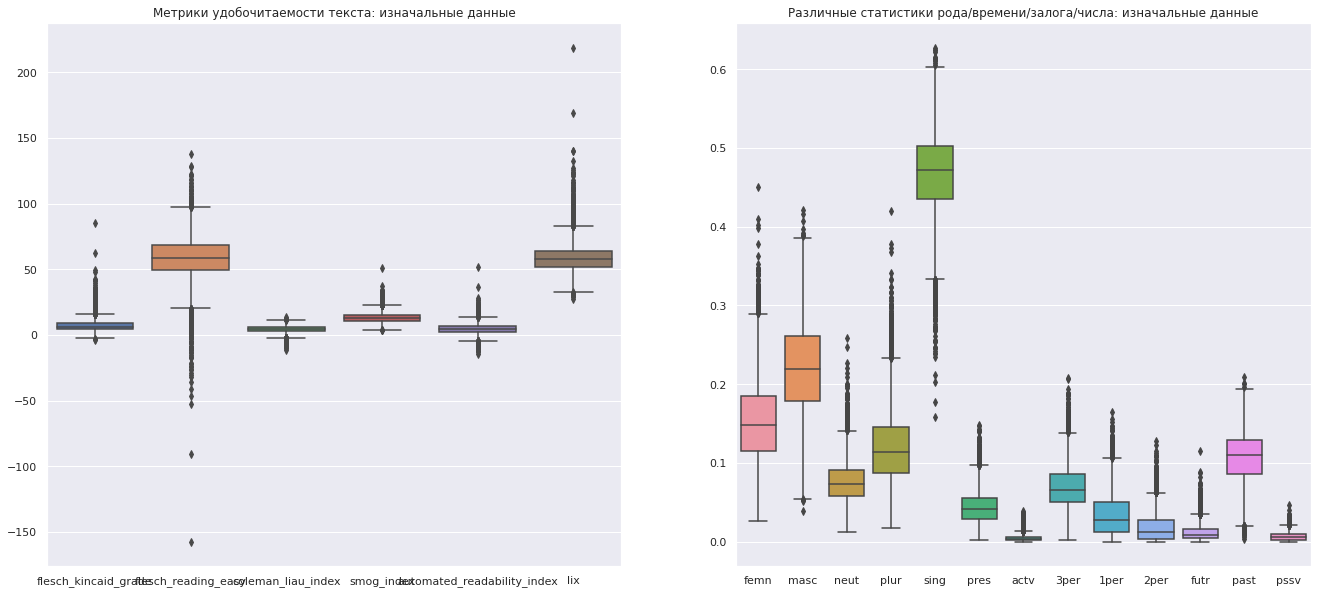

In [111]:
fig = plt.figure(figsize = (35, 10))

fig.add_subplot(131)
sns.boxplot(data=books[['flesch_kincaid_grade', 'flesch_reading_easy', 'coleman_liau_index',
       'smog_index', 'automated_readability_index', 'lix']])
plt.title('Метрики удобочитаемости текста: изначальные данные', fontsize=12)

fig.add_subplot(132)
sns.boxplot(data=books[['femn', 'masc',
       'neut', 'plur', 'sing', 'pres', 'actv', '3per', '1per', '2per', 'futr',
       'past', 'pssv']])
plt.title('Различные статистики рода/времени/залога/числа: изначальные данные', fontsize=12)
plt.show()


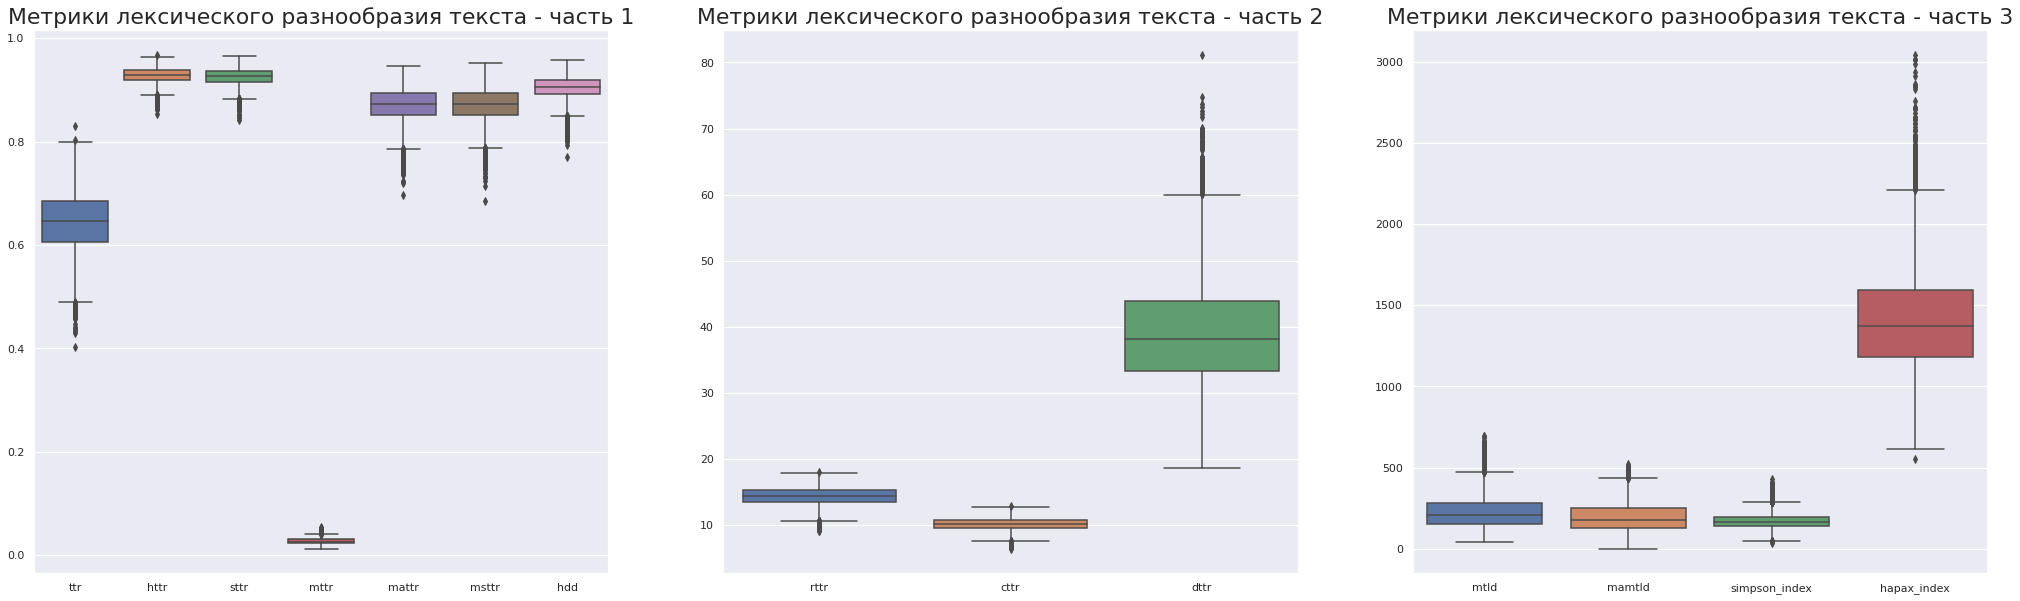

In [112]:
fig = plt.figure(figsize = (35, 10))

fig.add_subplot(131)
sns.boxplot(data=books[['ttr',
       'httr', 'sttr', 'mttr', 'mattr', 'msttr',
       'hdd']])
plt.title('Метрики лексического разнообразия текста - часть 1', fontsize=22)

fig.add_subplot(132)
sns.boxplot(data=books[['rttr', 'cttr', 'dttr']])
plt.title('Метрики лексического разнообразия текста - часть 2', fontsize=22)

fig.add_subplot(133)
sns.boxplot(data=books[['mtld', 'mamtld', 'simpson_index', 'hapax_index']])
plt.title('Метрики лексического разнообразия текста - часть 3', fontsize=22)

plt.show()

In [113]:
lower_bound = books['flesch_reading_easy'].quantile(q=0.01)
upper_bound = books['flesch_reading_easy'].quantile(q=0.99)

to_easy = books[books['flesch_reading_easy'] > upper_bound]
to_hard = books[books['flesch_reading_easy'] < lower_bound]

print(list(set(to_easy.index[:-16]))[:3]) # посмотрим примеры выбросов
print(list(set(to_hard.index[:-16]))[:3])
# формула: c - (a * n_words / n_sents) - (b * n_syllables / n_words), a,b,c - параметры со значениями по умолчанию

['7337 maksim-gorkii na-dne', '7324 maksim-gorkii na-dne', '6589 lev-tolstoi voina-i-mir']
['6380 lev-tolstoi voina-i-mir', '4155 ivan-goncharov obryv', '4033 ivan-goncharov obryv']


In [114]:
print('flesch_reading_easy =', books['flesch_reading_easy'][7324])
original_text['text'][7324].strip().replace('\n', '') # пример слишком простого текста

flesch_reading_easy = 97.66700210671608


'Сатин (смеясь) . Не понимаешь? Жену ищет… И чего ты не пришибешь его, Василий?!  Пепел . Стану я из-за такой дряни жизнь себе портить…  Сатин . А ты — умненько. Потом — женись на Василисе… хозяином нашим будешь…  Пепел . Велика радость! Вы не токмо все мое хозяйство, а и меня, по доброте моей, в кабаке пропьете… (Садится на нары.) Старый черт… разбудил… А я — сон хороший видел: будто ловлю я рыбу, и попал мне — огромаднейший лещ! Такой лещ, — только во сне эдакие и бывают… И вот я его вожу на удочке и боюсь, — леса оборвется! И приготовил сачок… вот, думаю, сейчас…  Сатин . Это не лещ, а Василиса была…  Актер . Василису он давно поймал…  Пепел (сердито) . Подите вы к чертям… да и с ней вместе!  Клещ (входит из сеней) . Холодище… собачий…  Актер . Ты что же Анну не привел? Замерзнет…  Клещ . Ее Наташка в кухню увела к себе…  Актер . Старик — выгонит.  Клещ (садясь работать) . Ну… Наташка приведет…  Сатин . Василий. Дай пятак…  Актер (Сатину) . Эх ты… пятак! Вася! Дай нам двугривенный… 

In [49]:
print('flesch_reading_easy =', books['flesch_reading_easy'][4033])
original_text['text'][4033].strip().replace('\n', '') # пример слишком сложного текста

flesch_reading_easy = 8.663301886792453


'Подле тяжелого буля стояла откидная кушетка от Гамбса, высокий, готический камин прикрывался ширмами с картинами фоблазовских нравов, на столах часто утро заставало остатки ужина, на диване можно было найти иногда женскую перчатку, ботинку, в уборной его — целый магазин косметических снадобьев.Как тихо и молчаливо было наверху, так внизу слышались часто звонкие голоса, смех, всегда было там живо, беспорядочно. Камердинер был у него француз с почтительной речью и наглым взглядом.IIIМного комнат прошли Райский и Аянов, прежде нежели добрались до жилья, то есть до комнат, где сидели обе старухи и Софья Николаевна.Когда они вошли в гостиную, на них захрипела моська, но не смогла полаять и, повертевшись около себя, опять улеглась.Анна Васильевна кивнула им, а Надежда Васильевна, в ответ на поклоны, ласково поглядела на них, с удовольствием высморкалась и сейчас же понюхала табаку, зная, что у ней будет партия.— Ма cousine! — сказал Райский, протянув руку Беловодовой.Она поклонилась с улыбк

In [115]:
lower_bound = books['mttr'].quantile(q=0.01)
upper_bound = books['mttr'].quantile(q=0.99)

to_diverse = books[books['mttr'] > upper_bound]
to_similar = books[books['mttr'] < lower_bound]

print(list(set(to_diverse.index[:-16]))[:3])
print(list(set(to_similar.index[:-16]))[:3])
# формула: (log10(n_words) - log10(n_lexemes)) / log10(n_words) ** 2

['5405 lev-tolstoi anna-karenina', '3199 fedor-dostoevskii unizhennye-i-oskorblennye', '4953 ivan-turgenev zapiski-okhotnika']
['8004 maksim-gorkii zhizn-klima-samgina', '8541 maksim-gorkii zhizn-klima-samgina', '8411 maksim-gorkii zhizn-klima-samgina']


In [116]:
print('mttr =', books['mttr'][4953])
original_text['text'][4953].strip().replace('\n', '') # пример слишком разнообразного текста

mttr = 0.0432546670654071


'До самой полуночи все металась; наконец словно заснула; по крайней мере, не шевелится, лежит. Лампада в углу перед образом горит. Я сижу, знаете, потупился, дремлю тоже. Вдруг, словно меня кто под бок толкнул, обернулся я… Господи, Боже мой! Александра Андреевна во все глаза на меня глядит… губы раскрыты, щеки так и горят. «Что с вами?» — «Доктор, ведь я умру?» — «Помилуй Бог!» — «Нет, доктор, нет, пожалуйста, не говорите мне, что я буду жива… не говорите… если б вы знали… послушайте, ради Бога не скрывайте от меня моего положения! — А сама так скоро дышит. — Если я буду знать наверное, что я умереть должна… я вам тогда все скажу, все!» — «Александра Андреевна, помилуйте!» — «Послушайте, ведь я не спала нисколько, я давно на вас гляжу… ради Бога… я вам верю, вы человек добрый, вы честный человек, заклинаю вас всем, что есть святого на свете, — скажите мне правду! Если б вы знали, как это для меня важно… Доктор, ради Бога скажите, я в опасности?» — «Что я вам скажу, Александра Андреевн

In [117]:
print('mttr =', books['mttr'][8411])
original_text['text'][8411].strip().replace('\n', '') # пример слишком однообразного текста

mttr = 0.022088718656496


'Он спросил: почему — песенник? Она любит стихи?  — Нет, стихов — не люблю, очень трудно понимать. Я люблю простые песни.  И тихонько, слабеньким голосом, она пропела две песни, одну, пошлую, Самгин отверг, а другую даже записал. На его вопрос — любила Анюта кого-нибудь? — она ответила:  — Нет, не случалось. Знаете, в нашем деле любовь приедается. Хотя иные девицы заводят "кредитных", вроде как любовников, и денег с них не берут, но это только так, для игры, для развлечения от скуки.  Потом он спросил: бывает ли, что мужчины грубо обращаются с нею? Она как будто немножко обиделась.  — За что же грубить? Я — ласковая, хорошенькая, пьяной — не бываю. Дом у нас приличный, вы сами знаете. Гости — очень известные, скандалить — стесняются. Нет, у нас — тихо. Даже — скучно бывает.  Говорила она стоя пред зеркалом, заплетая в косу обильные и мягкие светлорусые волосы, голая, точно куриное яйцо.  — А вот во время революции интересно было, новые гости приходили, такое, знаете, оживление. Один, с

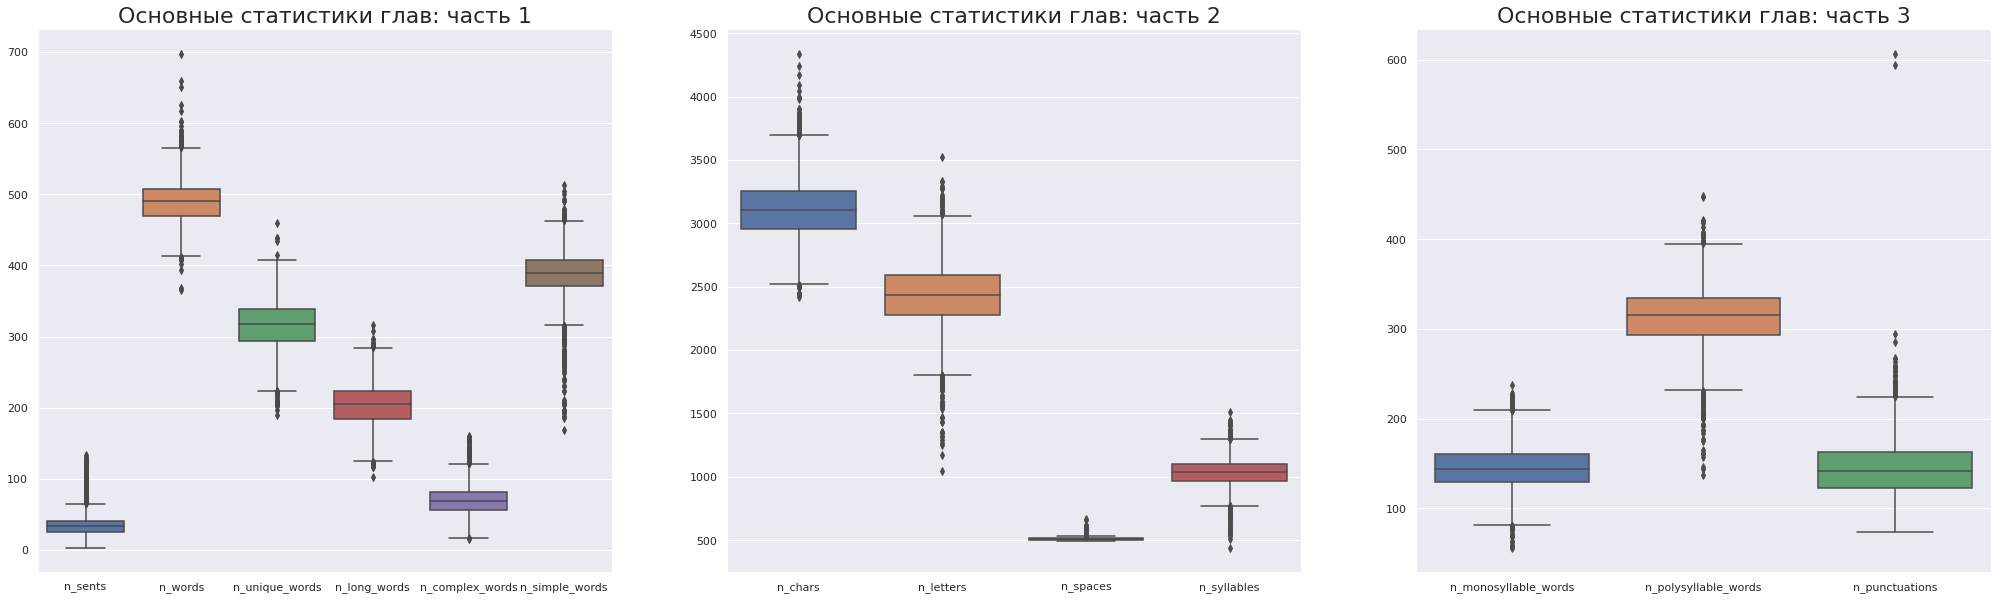

In [118]:
fig = plt.figure(figsize = (35, 10))

fig.add_subplot(131)
sns.boxplot(data=books[['n_sents', 'n_words', 'n_unique_words', 'n_long_words',
       'n_complex_words', 'n_simple_words']])
plt.title('Основные статистики глав: часть 1', fontsize=22)

fig.add_subplot(132)
sns.boxplot(data=books[['n_chars', 'n_letters', 'n_spaces',
       'n_syllables']])
plt.title('Основные статистики глав: часть 2', fontsize=22)

fig.add_subplot(133)
sns.boxplot(data=books[['n_monosyllable_words',
       'n_polysyllable_words', 'n_punctuations']])
plt.title('Основные статистики глав: часть 3', fontsize=22)

plt.show()

In [119]:
lower_bound = df['n_unique_words'].quantile(q=0.01)
upper_bound = df['n_unique_words'].quantile(q=0.99)

to_big = df[df['n_unique_words'] > upper_bound]
to_small = df[df['n_unique_words'] < lower_bound]

print(list(set(to_big.index[:-16]))[:3])
print(list(set(to_small.index[:-16]))[:3])

['8753 nikolai-gogol myortvye-dushi', '8573 maksim-gorkii zhizn-klima-samgina', '7760 maksim-gorkii zhizn-klima-samgina']
['5405 lev-tolstoi anna-karenina', '1341 fedor-dostoevskii besy', '2041 fedor-dostoevskii bratya-karamazovy']


In [120]:
print('n_unique_words =', books['n_unique_words'][7760])
original_text['text'][7760].strip().replace('\n', '') # пример где слишком много длинных слов

n_unique_words = 342.0


'— Главный кирпич не в карнизе, а в фундаменте. Всякий бык теленком был, — то и дело вставлял он в свою речь. Смотреть на него было так же приятно, как слушать его благожелательную речь, обильную мягкими словами, тускловатый блеск которых имел что-то общее с блеском старого серебра в шкафе. Тонкие руки с кистями темных пальцев двигались округло, легко, расписанное лицо ласково морщилось, шевелились белые усы, и за стеклами очков серенькие зрачки напоминали о жемчуге риз на иконах. Он вкусно пил чай, вкусно грыз мелкими зубами пресные лепешки, замешанные на сливках, от него, как от плодового дерева, исходил приятный запах. Клим незаметно для себя просидел с ним до полуночи и вышел на улицу с благодушной улыбкой. Чувство, которое разбудил в нем старик, было сродно умилению, испытанному на выставке, но еще более охмеляющим. Ночь была теплая, но в садах тихо шумел свежий ветер, гоня по улице волны сложных запахов. В маленьком, прозрачном облаке пряталась луна, правильно круглая, точно желт

In [121]:
print('n_unique_words =', books['n_unique_words'][2041])
original_text['text'][2041].strip().replace('\n', '') # пример где слишком мало длинных слов

n_unique_words = 225.0


'Только верите ли, эта сцена все-таки была натуральна, потому что я даже расплакалась, и несколько дней потом плакала, а потом вдруг после обеда все и позабыла. Вот он и перестал ходить уже две недели, я и думаю: да неужто ж он совсем не придет? Это еще вчера, а вдруг к вечеру приходят эти Слухи. Прочла и ахнула, ну кто же написал, это он написал, пришел тогда домой, сел — и написал; послал — и напечатали. Ведь это две недели как было. Только, Алеша, ужас я что говорю, а вовсе не говорю об чем надо? Ах, само говорится!  — Мне сегодня ужасно как нужно поспеть во-время к брату, — пролепетал было Алеша.  — Именно, именно! Вы мне все напомнили! Послушайте, что такое афект?  — Какой афект? — удивился Алеша.  — Судебный афект. Такой афект, за который все прощают. Что бы вы ни сделали — вас сейчас простят.  — Да вы про что это?  — А вот про что: эта Катя… Ах это милое, милое существо, только я никак не знаю, в кого она влюблена. Недавно сидела у меня, и я ничего не могла выпытать. Тем более, 

In [122]:
# удаляем некоторые метрики
books = books.drop(['n_sents', 'n_words', 'n_unique_words', 'n_long_words',
       'n_complex_words', 'n_simple_words', 'n_monosyllable_words',
       'n_polysyllable_words', 'n_chars', 'n_letters', 'n_spaces',
       'n_syllables', 'n_punctuations'], axis=1)

## Часть 2: Поведение признаков и связь с целевой переменной

Для начала придется закодировать целевую переменную - автора, т.к. сейчас это единственный категориальный столбец.

In [123]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

encoder = OrdinalEncoder()
books['author_num'] = encoder.fit_transform(np.array(books['author']).reshape(-1,1))

In [127]:
books['author_num'].value_counts()

2.0    2061
5.0    1997
6.0    1498
3.0    1255
1.0     728
4.0     660
8.0     581
7.0     533
0.0     438
Name: author_num, dtype: int64

In [128]:
books.describe()

,flesch_kincaid_grade,flesch_reading_easy,coleman_liau_index,smog_index,automated_readability_index,lix,masc,femn,neut,sing,...,mttr,dttr,mattr,msttr,mtld,mamtld,hdd,simpson_index,hapax_index,author_num
count,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,...,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000
mean,7.122198,57.754731,4.534718,13.407794,4.832547,58.561714,0.220524,0.152404,0.076019,0.465650,...,0.026630,39.094734,0.871388,0.871205,236.070299,192.715265,0.904631,171.419518,1412.639212,3.959286
std,4.504919,16.245418,2.682184,3.885634,3.714455,10.655166,0.058316,0.051731,0.025703,0.053444,...,0.005345,7.982151,0.031867,0.032495,114.254053,100.824307,0.021209,47.963382,315.835378,2.151322
min,-4.168028,-157.410785,-11.582535,3.437316,-14.397990,27.273184,0.038877,0.026585,0.012632,0.157996,...,0.012315,18.578103,0.696193,0.685000,42.872285,1.000000,0.769989,38.175095,550.337349,0.000000
25%,4.305243,49.078503,2.926811,10.793845,2.407195,51.566897,0.178571,0.115000,0.058065,0.434696,...,0.022754,33.234345,0.851077,0.851111,153.638332,129.038292,0.891654,137.716216,1182.796279,2.000000
50%,6.360431,58.895611,4.724324,12.895899,4.644102,57.595934,0.218623,0.147609,0.073171,0.471616,...,0.026192,38.179092,0.873443,0.873333,210.084389,179.181100,0.906333,164.361001,1374.129441,4.000000
75%,8.970127,68.361480,6.361921,15.512729,6.980738,63.983642,0.261663,0.184537,0.091314,0.502299,...,0.030089,43.948356,0.894457,0.894000,282.146668,252.151600,0.919591,197.053307,1594.483728,6.000000
max,85.437625,137.442441,13.516774,51.094425,51.777268,218.827586,0.421525,0.450855,0.258517,0.627397,...,0.053827,81.203779,0.946189,0.952500,695.270270,521.000000,0.958615,432.359551,3043.637707,8.000000


### 2.1 Корреляции признаков

Все признаки точно не придется одновременно использовать, потому что многие из них слишком похожи. Посмотрим на корреляции и уберем одинаковые.

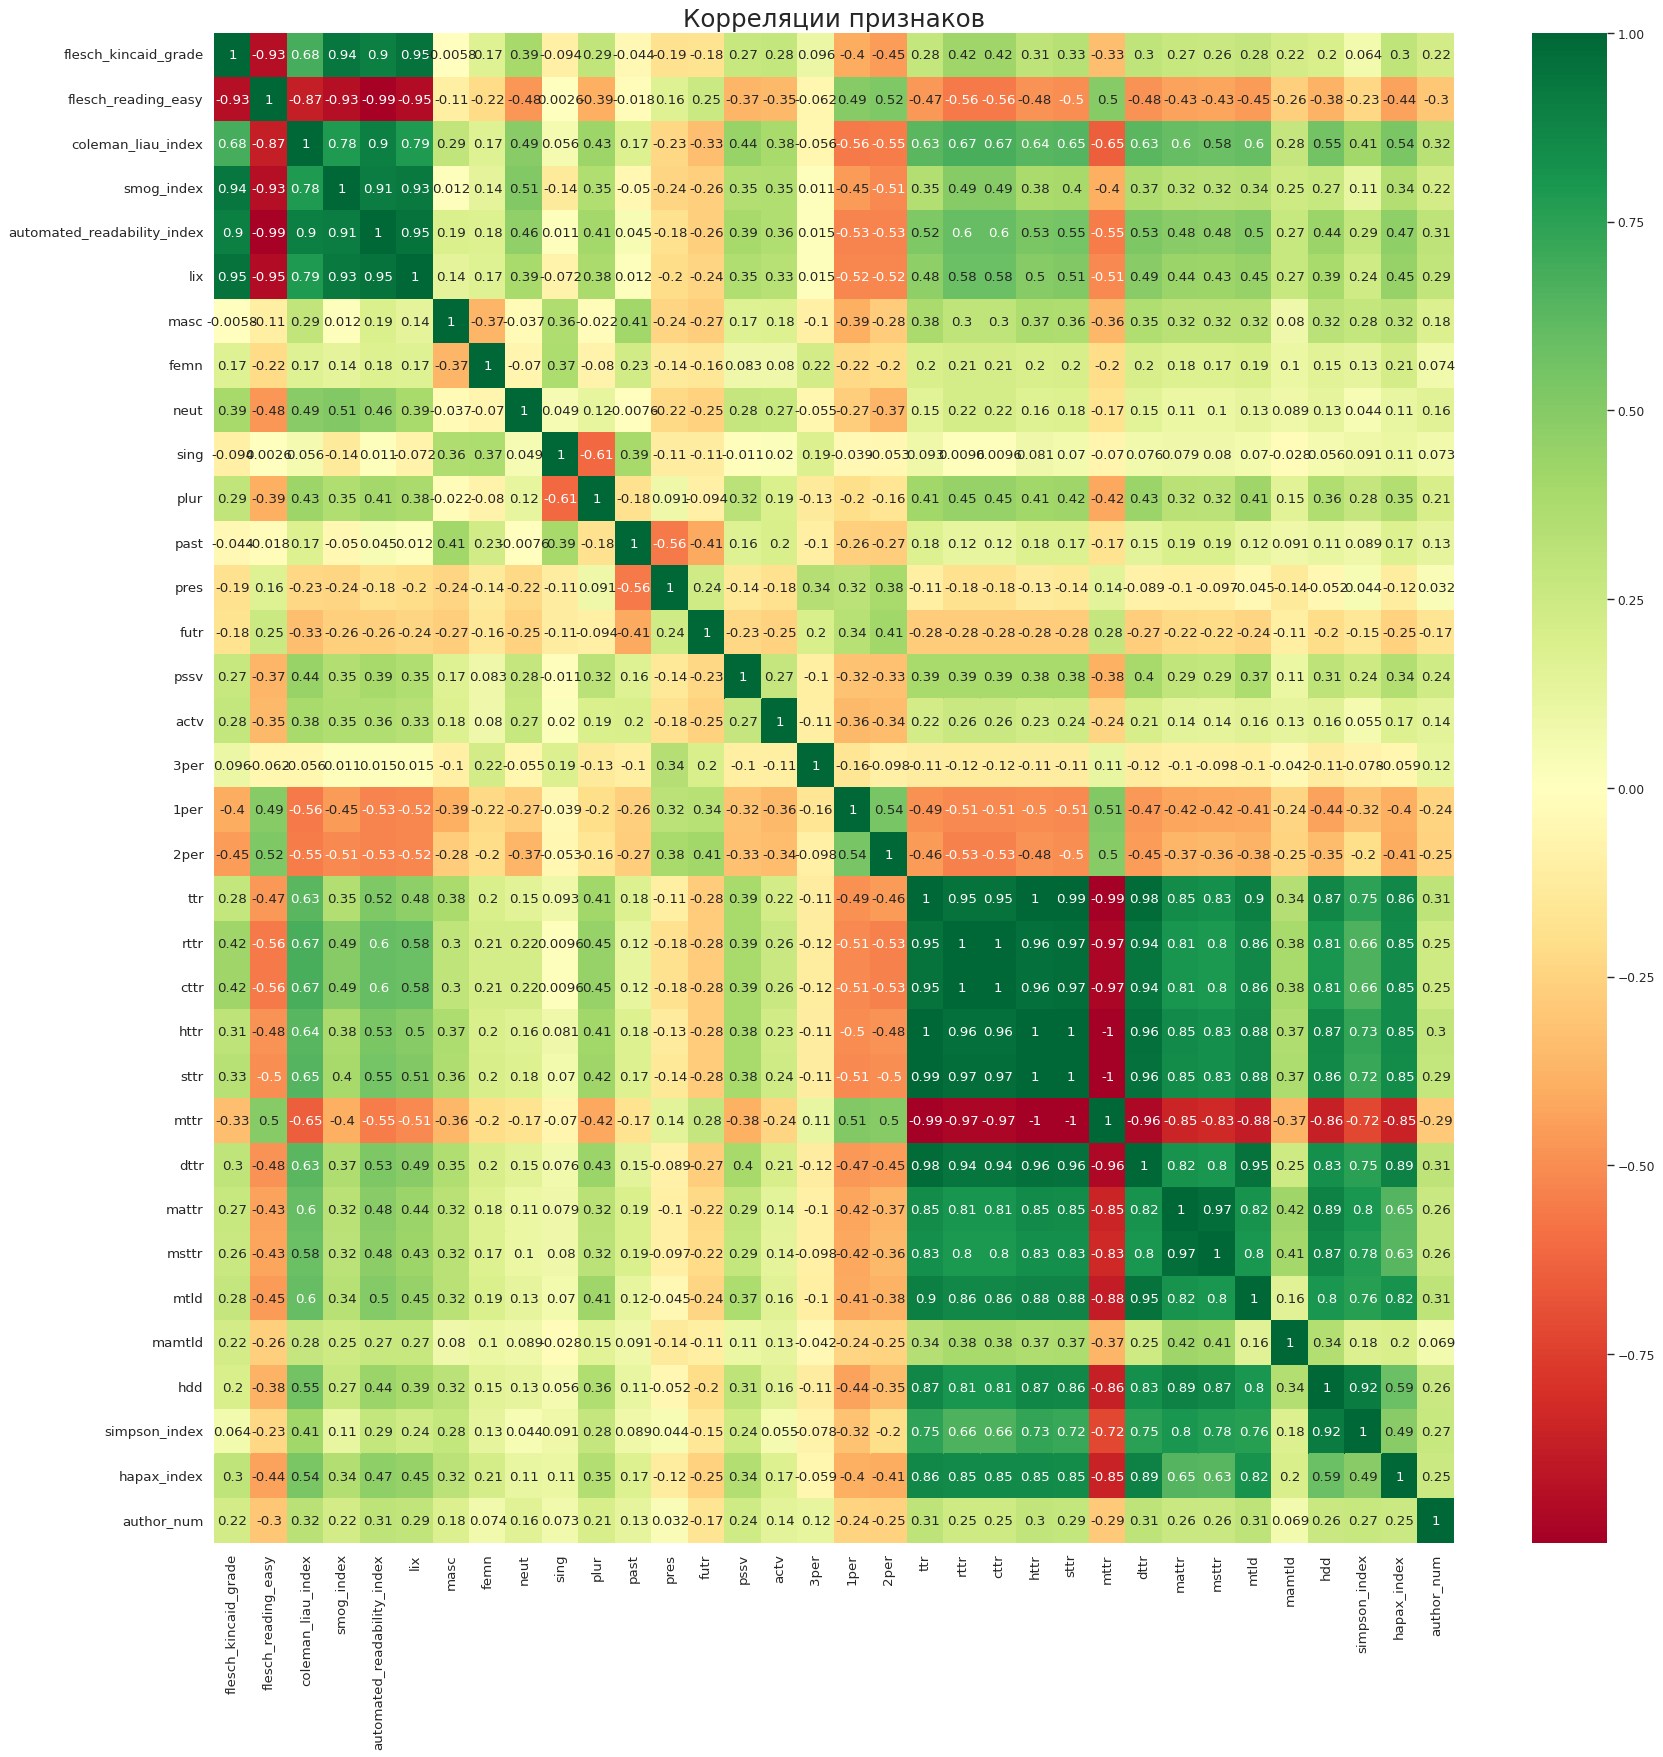

In [129]:
plt.figure(figsize=(25,25), dpi= 80)
sns.heatmap(books.corr(), xticklabels=books.corr().columns, yticklabels=books.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляции признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

* Судя по корреляциям, **метрики удобочитаемости текста** дают очень похожие результаты между собой, поэтому есть смысл оставить только какую-либо одну вместо всех. Можно оставить только **smog_index**. Чем больше значение этой метрики, тем сложнее текст.

* Также метрики лексического разнообразия похожи между собой, но среди них есть не только совсем одинаковые. Можно оставить такие:
  * **hdd** Наиболее достоверная реализация алгоритма VocD (2010, McCarthy & Jarvis). В основе алгоритм лежит метод случайного отбора из текста сегментов длиной от 32 до 50 слов и вычисления для них TTR с последующим усреднением.
  * **mttr** Модификация метрики TTR с использованием логарифмической функции (1966, Mass). Наиболее стабильная метрика в отношении длины текста.



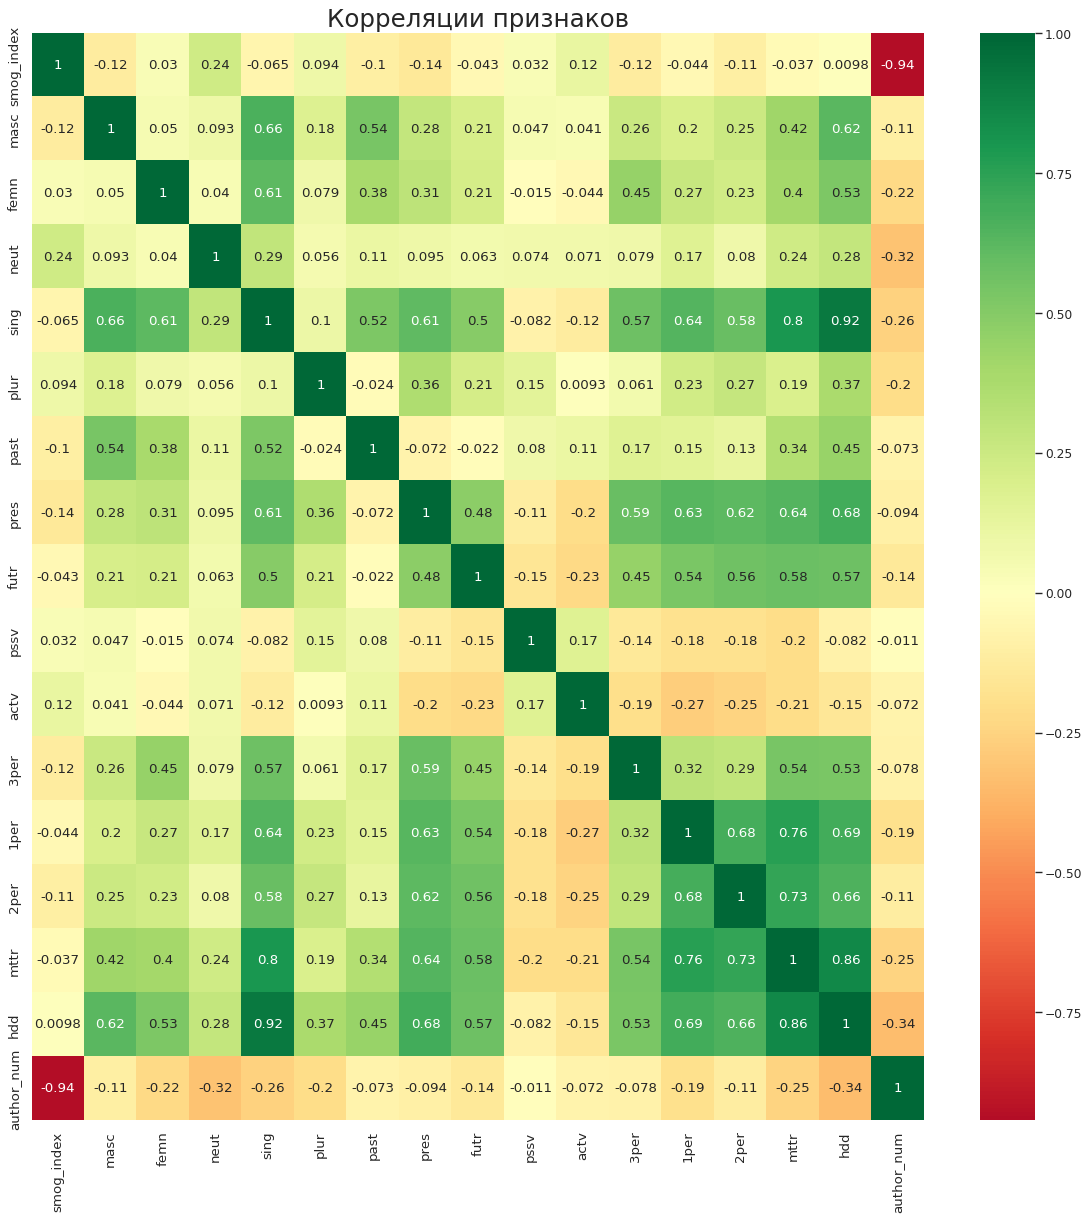

In [130]:
# удалим ненужные столбцы
books = books.drop(['flesch_kincaid_grade', 'flesch_reading_easy', 'coleman_liau_index', 'automated_readability_index',
                    'ttr', 'rttr', 'cttr', 'httr', 'sttr', 'dttr', 'mattr', 'msttr', 'mamtld', 'hapax_index', 'mtld', 
                    'simpson_index', 'lix'], axis=1)

authors_data = books['author']
books_norm = books.drop(['author'], axis=1)
# нормируем векторы
books_norm = books_norm.apply(lambda metric: metric/metric.sum(), axis=1)

# еще раз посмотрим на корреляции
plt.figure(figsize=(18,18), dpi= 80)
sns.heatmap(books_norm.corr(), xticklabels=books_norm.corr().columns, yticklabels=books_norm.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляции признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### 2.1 Поведение каждого признака в отдельности

In [131]:
def metrics_density_by_author(m):
  sns.set(rc={'figure.figsize':(15,10)})
  for author in books['author'].unique():
    snsplot = sns.kdeplot(books[books['author']==author][m], shade=True, label=author)
    fig = snsplot.get_figure()
    plt.legend()

In [132]:
books.columns

Index(['smog_index', 'masc', 'femn', 'neut', 'sing', 'plur', 'past', 'pres',
       'futr', 'pssv', 'actv', '3per', '1per', '2per', 'mttr', 'hdd', 'author',
       'author_num'],
      dtype='object')

Теперь рассмотрим распределения признаков отдельно для каждого автора.

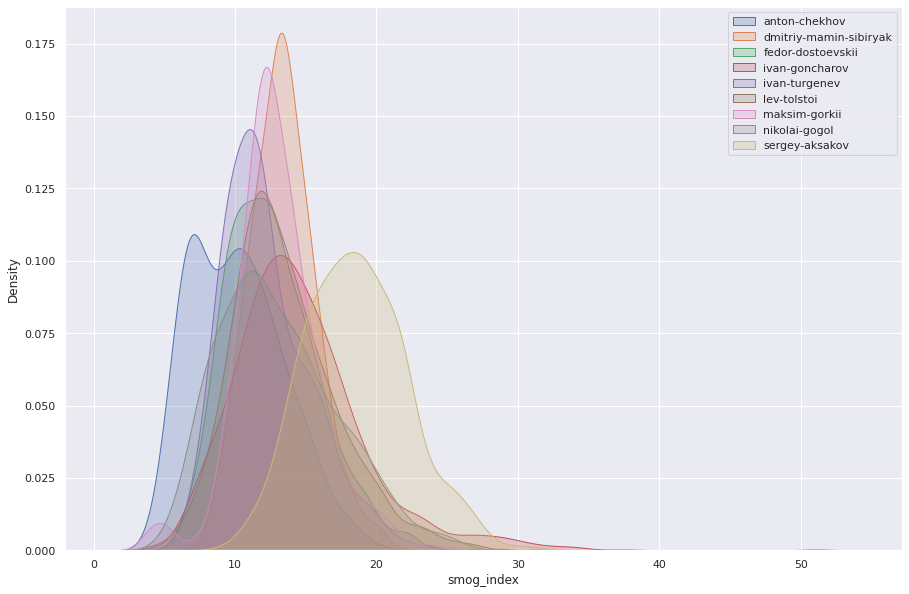

In [133]:
metrics_density_by_author('smog_index')

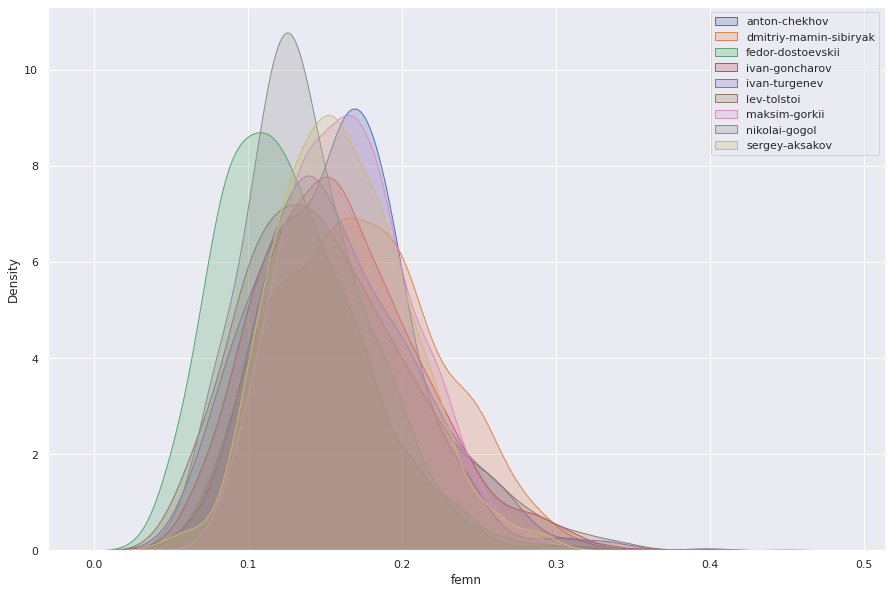

In [134]:
metrics_density_by_author('femn')

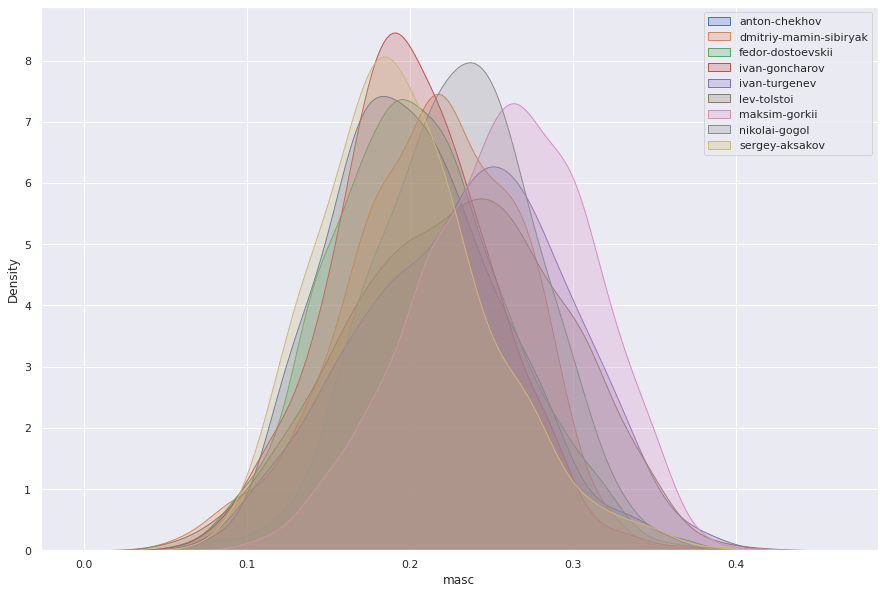

In [135]:
metrics_density_by_author('masc')

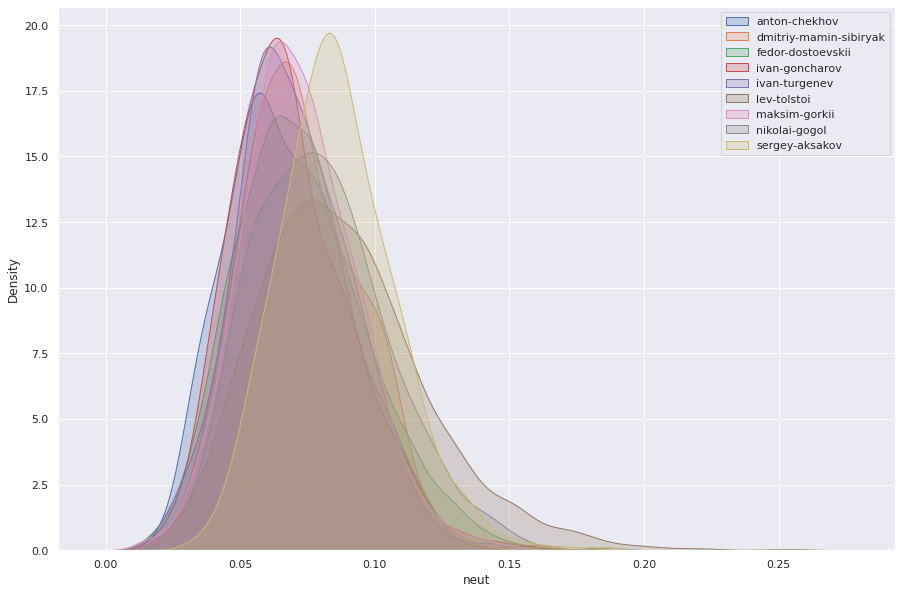

In [136]:
metrics_density_by_author('neut')

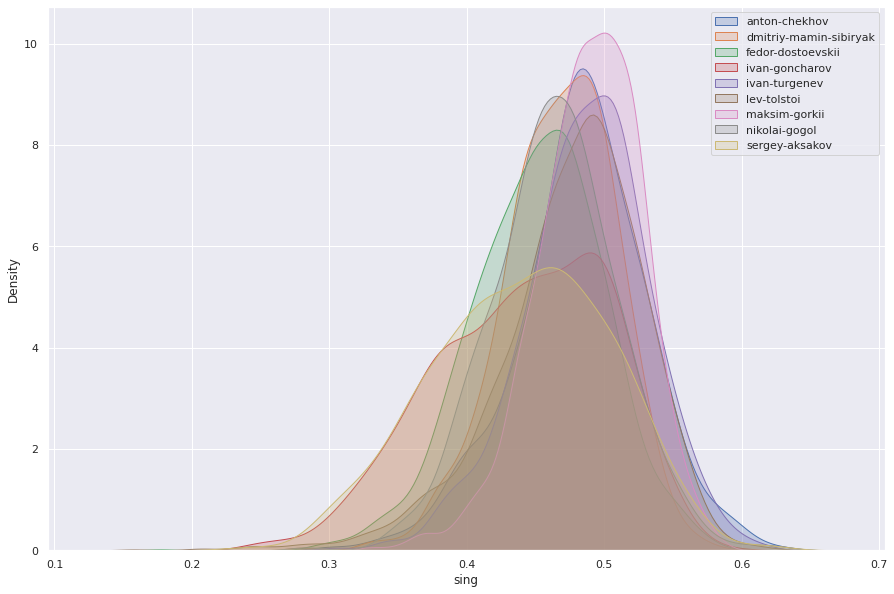

In [137]:
metrics_density_by_author('sing')

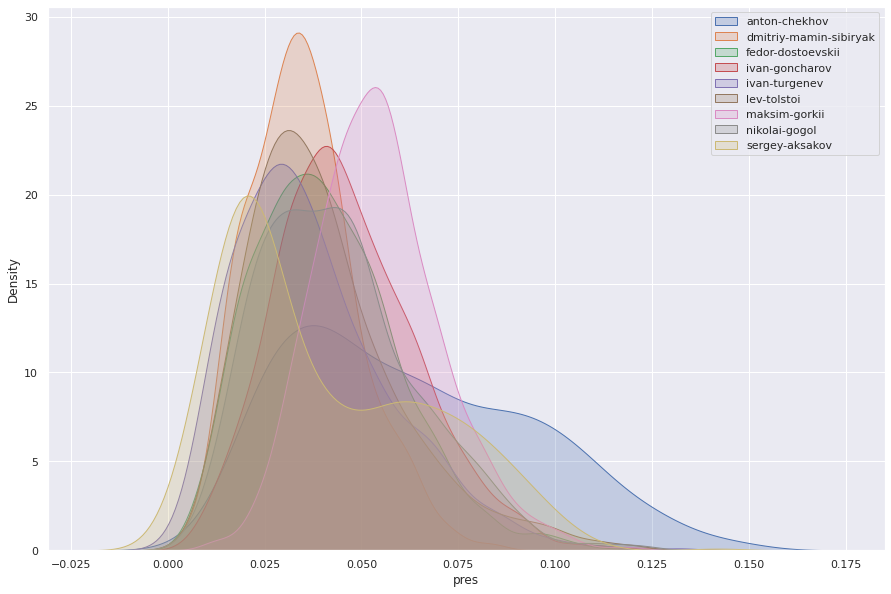

In [138]:
metrics_density_by_author('pres')

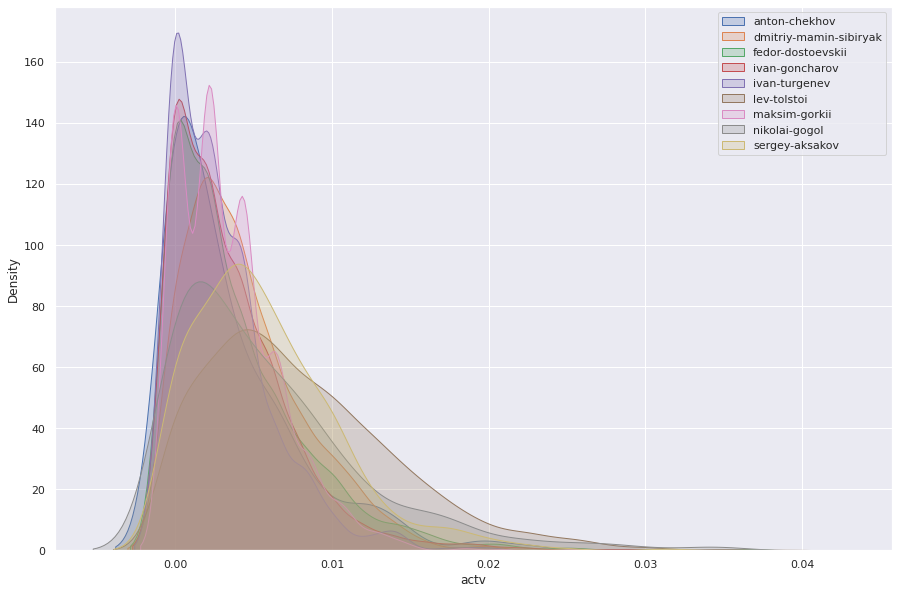

In [139]:
metrics_density_by_author('actv')

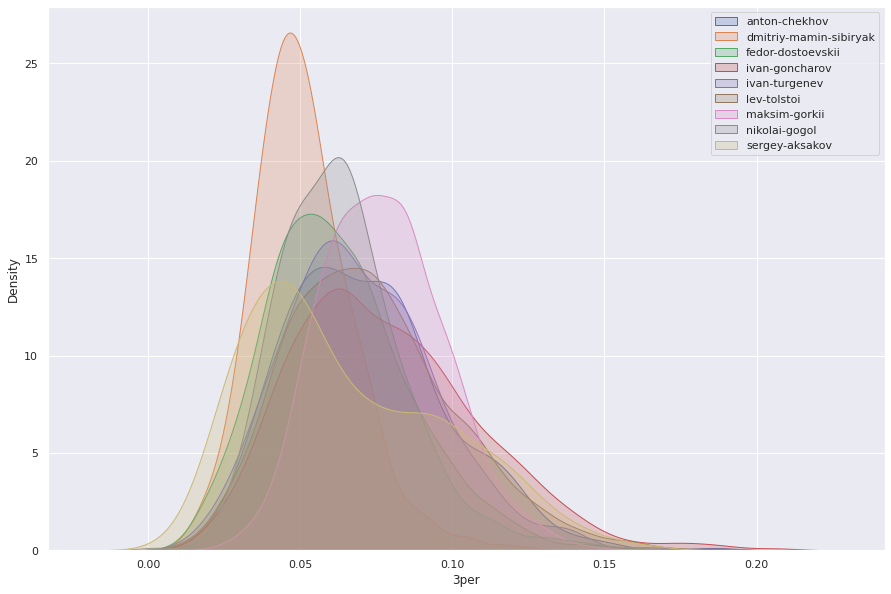

In [140]:
metrics_density_by_author('3per')

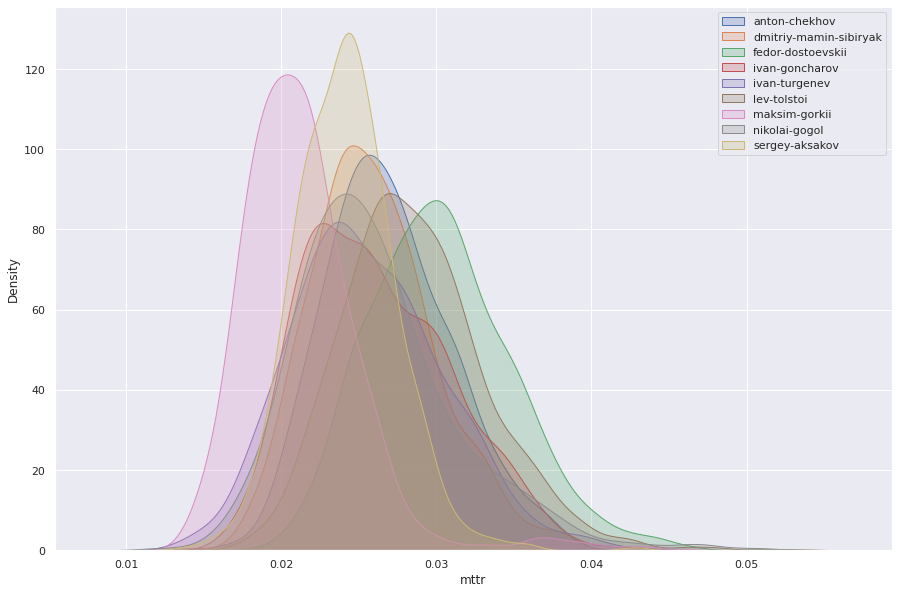

In [141]:
metrics_density_by_author('mttr')

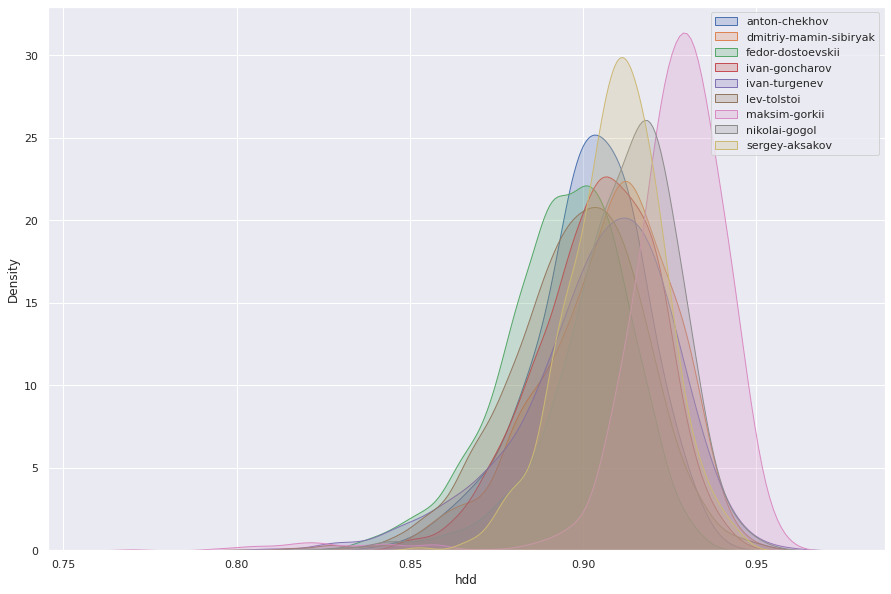

In [142]:
metrics_density_by_author('hdd')

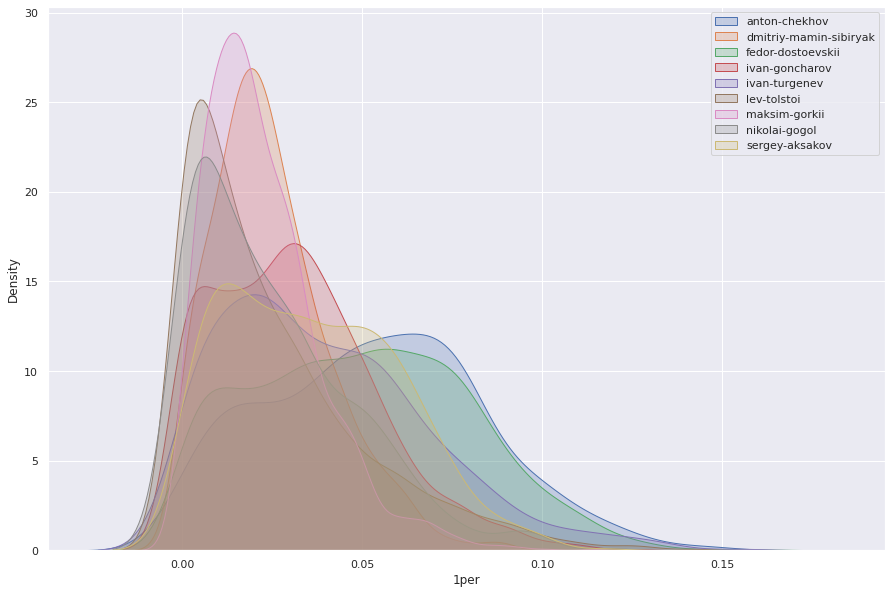

In [143]:
metrics_density_by_author('1per')

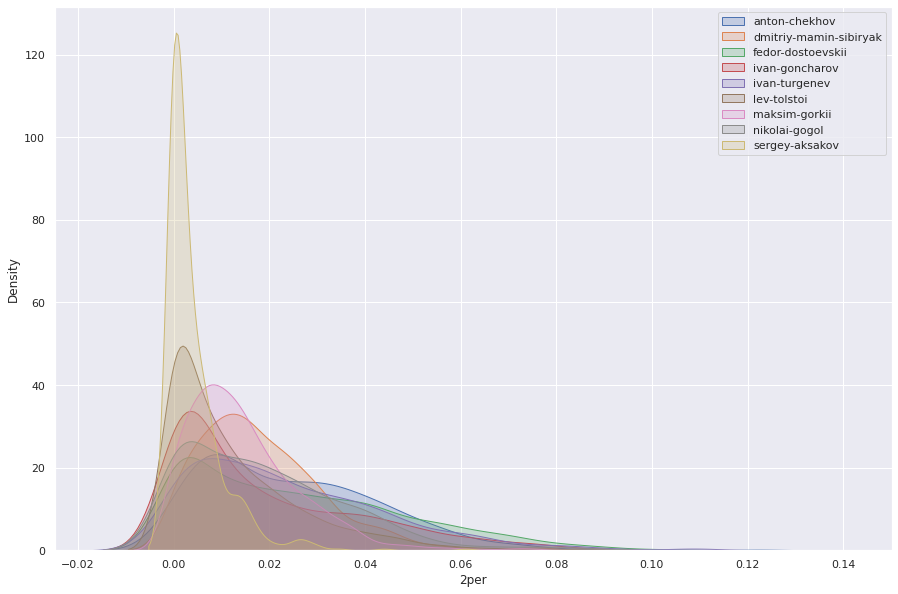

In [144]:
metrics_density_by_author('2per')

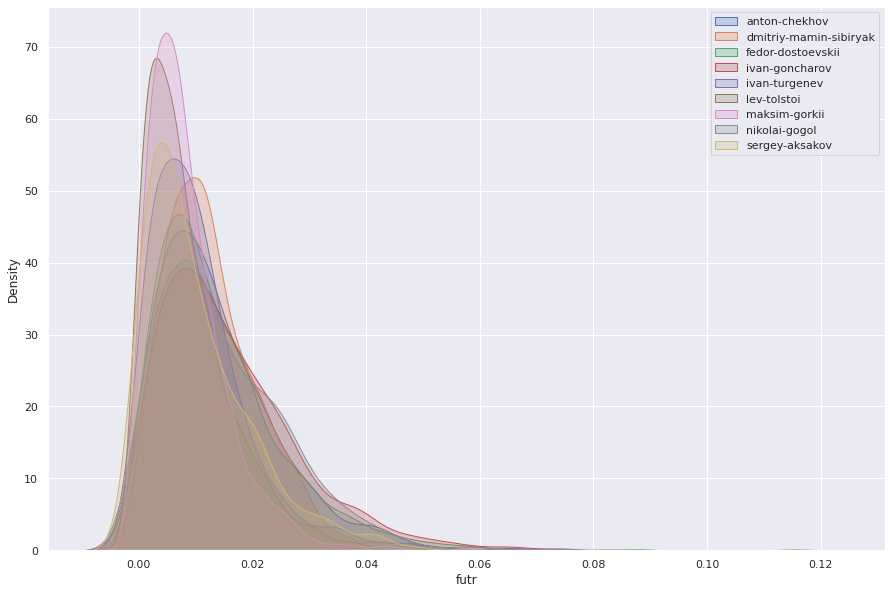

In [145]:
metrics_density_by_author('futr')

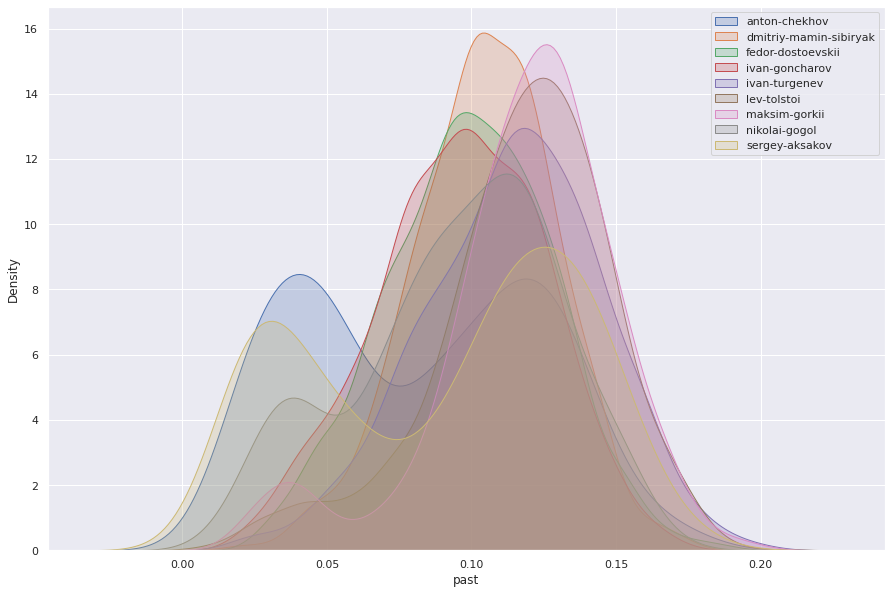

In [146]:
metrics_density_by_author('past')

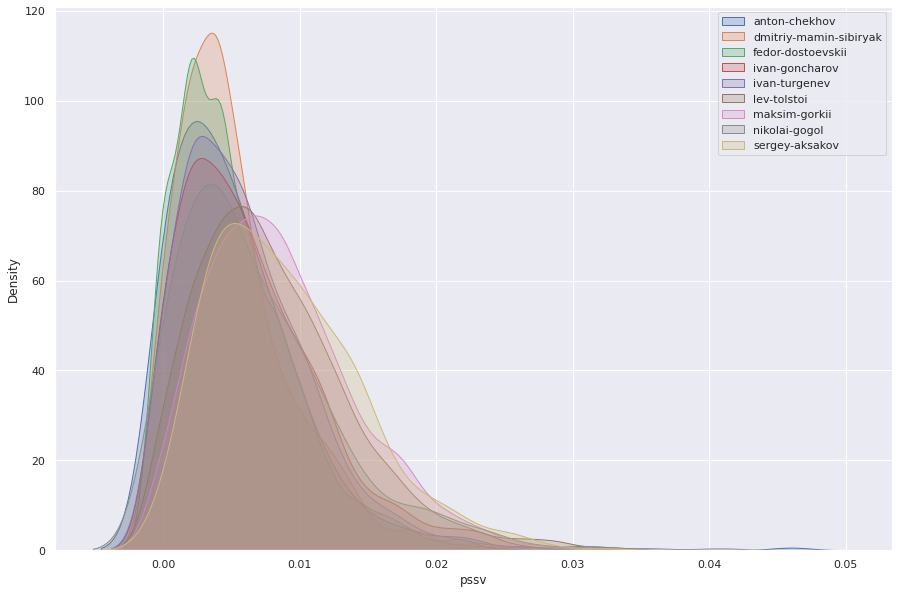

In [148]:
metrics_density_by_author('pssv')

In [149]:
books.drop(['author', 'author_num'], axis=1).columns

Index(['smog_index', 'masc', 'femn', 'neut', 'sing', 'plur', 'past', 'pres',
       'futr', 'pssv', 'actv', '3per', '1per', '2per', 'mttr', 'hdd'],
      dtype='object')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'Авторы')]

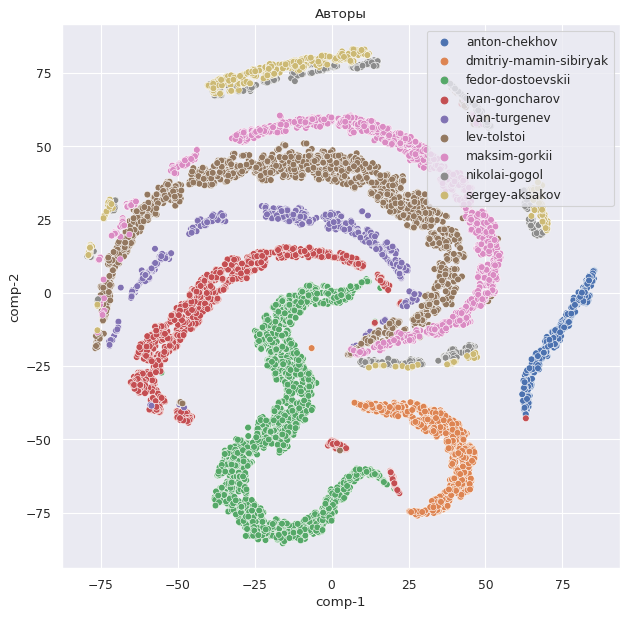

In [151]:
X = books_norm.drop(['author_num'], axis=1)

y = books['author']

plt.figure(figsize=(9,9), dpi=80)
tsne = TSNE(n_components=2, learning_rate=150)
z = tsne.fit_transform(X)

d = pd.DataFrame()
d["y"] = y
d["comp-1"] = z[:,0]
d["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=d.y.tolist(), data=d).set(title="Авторы") 

In [152]:
books.shape

(9751, 18)

In [153]:
books.columns

Index(['smog_index', 'masc', 'femn', 'neut', 'sing', 'plur', 'past', 'pres',
       'futr', 'pssv', 'actv', '3per', '1per', '2per', 'mttr', 'hdd', 'author',
       'author_num'],
      dtype='object')

In [154]:
books.to_csv('TRAIN_500words_lemmatized_metrics.csv')

# Обучение моделей

## 1. Импорт и обработка теста

In [157]:
# импорт тестового датасета

books = pd.read_csv('TRAIN_500words_lemmatized_metrics.csv', sep=',')
test = pd.read_csv('TEST_500words_lemmatized_metrics.csv', sep=',') 

for column in ['neut',
       'masc', 'femn', 'plur','sing', 'pres', 'past', 'futr', 'pssv', 'actv', '2per',
       '3per', '1per']:
    test[column] = test[column] / test['n_words'] # делаем проценты вместо чисел для некоторых показателей

test.drop(['flesch_kincaid_grade', 'flesch_reading_easy', 'coleman_liau_index', 'automated_readability_index',
                    'ttr', 'rttr', 'cttr', 'httr', 'sttr', 'dttr', 'mattr', 'msttr', 'mamtld', 'hapax_index', 'mtld', 
                    'simpson_index', 'lix'], axis=1, inplace=True) # удаляем очень похожие метрики

test.index = test['Unnamed: 0'] # переопределяем индекс

test.drop(['n_sents', 'n_words', 'n_unique_words', 'n_long_words',
       'n_complex_words', 'n_simple_words', 'n_monosyllable_words',
       'n_polysyllable_words', 'n_chars', 'n_letters', 'n_spaces',
       'n_syllables', 'n_punctuations', 'Unnamed: 22', 'Unnamed: 0'], axis=1, inplace=True)  # удаляем метрики, которые зависят от длины

print(test.shape)

(2033, 17)


In [158]:
# создание переменных для трейна и теста

X_train = books.drop(['author', 'author_num', 'Unnamed: 0'], axis=1)
y_train = books['author']

X_test = test.drop(['author'], axis=1).reindex(columns=X_train.columns).fillna(value=0)
y_test = test['author']

In [159]:
print(X_train.shape, X_train.columns)
print(X_test.shape, X_test.columns)

(9751, 16) Index(['smog_index', 'masc', 'femn', 'neut', 'sing', 'plur', 'past', 'pres',
       'futr', 'pssv', 'actv', '3per', '1per', '2per', 'mttr', 'hdd'],
      dtype='object')
(2033, 16) Index(['smog_index', 'masc', 'femn', 'neut', 'sing', 'plur', 'past', 'pres',
       'futr', 'pssv', 'actv', '3per', '1per', '2per', 'mttr', 'hdd'],
      dtype='object')


## 2. Логистическая регрессия

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [166]:
parameters = {'C': np.arange(1, 200, 3)}

model = LogisticRegression(multi_class='multinomial', max_iter=1000)
gs = GridSearchCV(model, parameters)

gs.fit(X_train, y_train)

gs.best_estimator_

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LogisticRegression(C=121, max_iter=1000, multi_class='multinomial')

In [186]:
best_model = LogisticRegression(multi_class='multinomial', max_iter=10000, C=121)
best_model.fit(X_train, y_train)

pred_logreg = best_model.predict(X_test)

f1_score(y_test, pred_logreg, average='micro')

0.38711264141662566

In [187]:
best_model.classes_

array(['anton-chekhov', 'dmitriy-mamin-sibiryak', 'fedor-dostoevskii',
       'ivan-goncharov', 'ivan-turgenev', 'lev-tolstoi', 'maksim-gorkii',
       'nikolai-gogol', 'sergey-aksakov'], dtype=object)

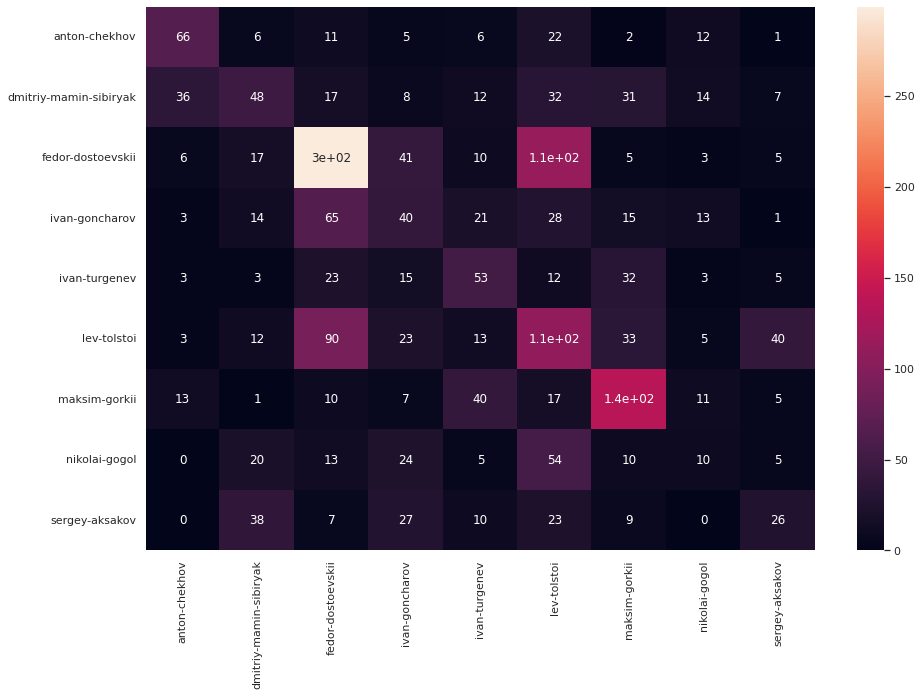

In [188]:
cm = confusion_matrix(y_test, pred_logreg, labels=best_model.classes_)
sns.heatmap(cm, xticklabels=best_model.classes_, yticklabels=best_model.classes_, annot=True)

## 3. KNN

In [183]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors': np.arange(3, 20, 2), 'weights': ['uniform', 'distance']}

model = KNeighborsClassifier()
gs = GridSearchCV(model, parameters)

gs.fit(X_train, y_train)

gs.best_estimator_

KNeighborsClassifier(n_neighbors=15, weights='distance')

In [184]:
best_model = gs.best_estimator_
best_model.fit(X_train, y_train)

pred_kn = best_model.predict(X_test)

f1_score(y_test, pred_kn, average='micro')

0.31874077717658633

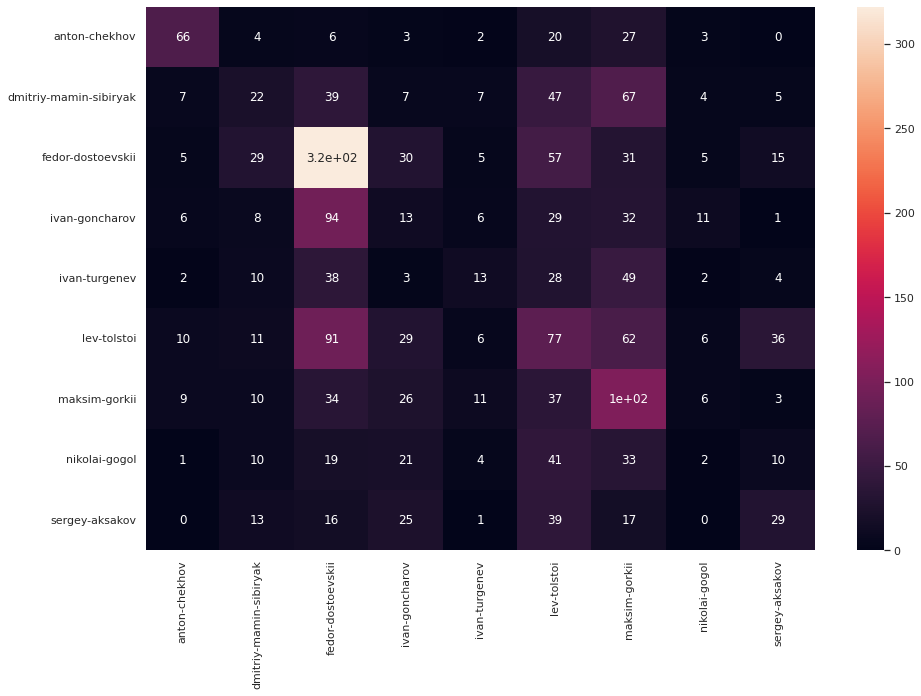

In [185]:
cm = confusion_matrix(y_test, pred_kn, labels=best_model.classes_)
sns.heatmap(cm, xticklabels=best_model.classes_, yticklabels=best_model.classes_, annot=True)

## 4. Catboost

In [196]:
!pip install catboost
from sklearn.model_selection import train_test_split as tts
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 21 kB/s 


In [197]:
model = CatBoostClassifier()
model.fit(X_train, y_train, silent=True)

In [198]:
preds = model.predict(X_test)
f1_score(preds, y_test, average='micro')

0.3792424987702902

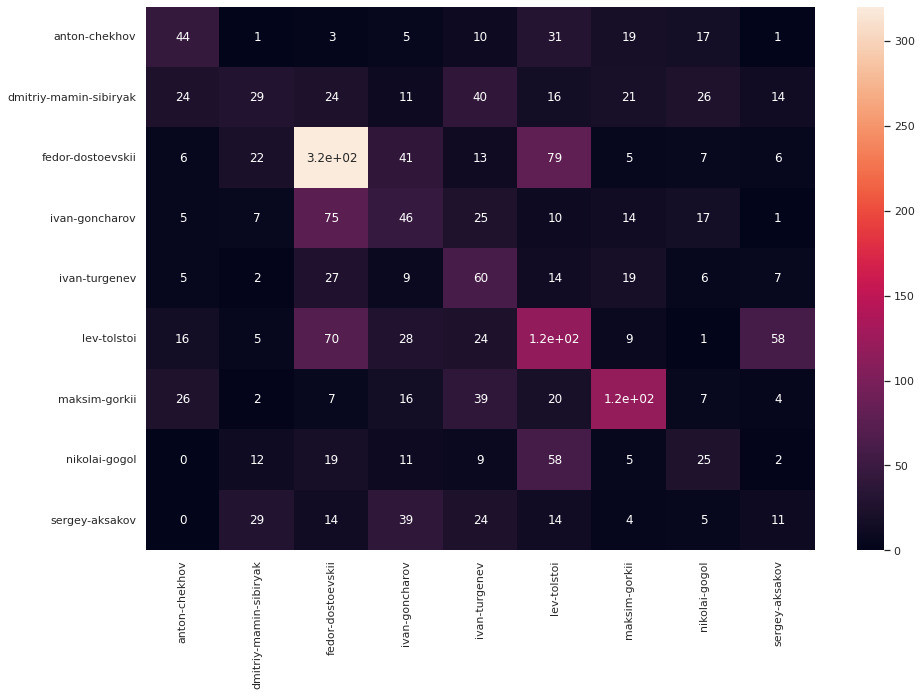

In [199]:
cm = confusion_matrix(y_test, preds, labels=model.classes_)
sns.heatmap(cm, xticklabels=model.classes_, yticklabels=model.classes_, annot=True)

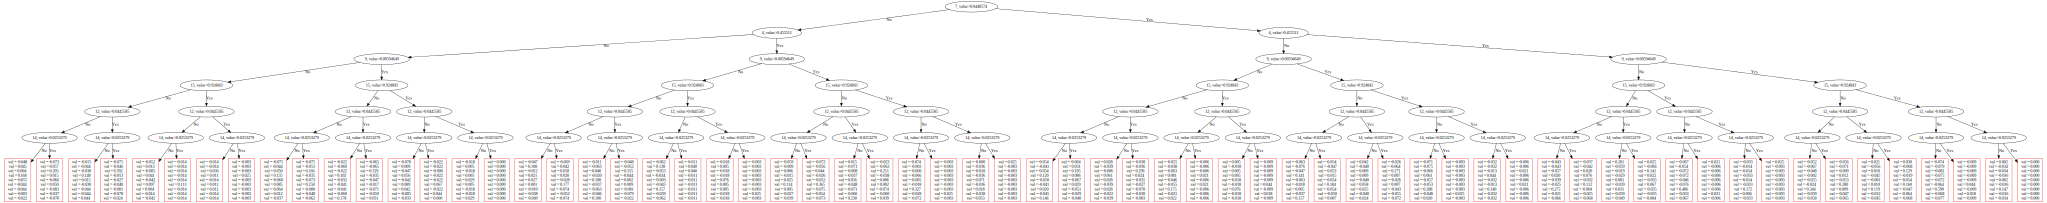

In [200]:
model.plot_tree(tree_idx=0)